In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

change to the directory contating training_dataset and testing_dataset

In [ ]:
# %cd /content/drive/MyDrive/DIP
# %cd /home/nitro5_wsl/projects/DIP/Test

/home/nitro5_wsl/projects/DIP/Test


In [3]:
# install packages
%pip install albumentations
%pip install opencv-python
%pip install segmentation_models_pytorch
%pip install natsort
%pip install monai

Utility function

In [4]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import random

# plot loss curve
def plot_loss_curve(history):
    plt.cla()
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x.get('valid_loss') for x in history]
    plt.plot(train_losses, '-bx',label='train')
    plt.plot(val_losses, '-rx',label='valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')
    plt.legend()
    plt.savefig('loss_curve.png')

# plot accuracy curve
def plot_accuracy_curve(history):
    plt.cla()
    psnrs = [x.get('accuracy') for x in history]
    plt.plot(psnrs, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('accuracy vs. No. of epochs');
    plt.savefig('accuracy.png')

# plot lr curve
def plot_lr_curve(history):
    plt.cla()
    lrs = [x.get('lrs') for x in history]
    plt.plot(lrs, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('lr')
    plt.title('lr vs. No. of epochs');
    plt.savefig('lr_curve.png')


def preprocess_image_draw_countour_2014(args):
    '''
    root = 'training_dataset' or 'testing_dataset'
    '''
    root, path = args
    # Suppress OpenCV thread spawning error messages
    os.environ["OPENCV_LOG_LEVEL"] = "SILENT"
    # Configure OpenCV to use a single thread
    cv2.setNumThreads(1)

    image = cv2.imread(os.path.join(root, 'image', path))

    # 將彩色圖像轉換到 YCrCb 色彩空間
    image_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # 對 Y 通道（亮度）進行直方圖均衡化
    y, cr, cb = cv2.split(image_ycrcb)
    y_eq = cv2.equalizeHist(y)

    # 合併處理後的亮度通道與原始的 Cr、Cb 通道
    image_ycrcb_eq = cv2.merge((y_eq, cr, cb))

    # 將圖像轉回 RGB 色彩空間
    equalized_image = cv2.cvtColor(image_ycrcb_eq, cv2.COLOR_YCrCb2BGR)
    # equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2BGR)
    # gaussian_blurred_image = cv2.GaussianBlur(equalized_image, (9, 9), 0)

    sobel_x = cv2.Sobel(equalized_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(equalized_image, cv2.CV_64F, 0, 1, ksize=3)

    gray = cv2.cvtColor(equalized_image, cv2.COLOR_BGR2GRAY)
    # ksize = 31  # Filter size
    # sigma = 4.0
    # theta = np.pi / 4
    # lambd = 10.0
    # gamma = 0.5
    # psi = 0
    # gabor_kernel = cv2.getGaborKernel(
    #     (ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F
    # )

    # Apply Gabor filter
    # gray = cv2.filter2D(gray, cv2.CV_8UC3, gabor_kernel)

    edges = cv2.Canny(gray, 100, 300)
    kernel = np.ones((5, 5), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 50]

    result = np.zeros_like(image)
    cv2.drawContours(result, contours, -1, (255, 255, 255), thickness=1)


    cv2.imwrite(os.path.join(root, 'processed_image', path), result)
    return result

def preprocess_image_fill_color_1735(args):
    '''
    root = 'dataset' or 'testing_dataset'
    '''
    root, path = args
    # Suppress OpenCV thread spawning error messages
    os.environ["OPENCV_LOG_LEVEL"] = "SILENT"
    # Configure OpenCV to use a single thread
    cv2.setNumThreads(1)

    image = cv2.imread(os.path.join(root, 'ms_image', path))

    gaussian_blurred_image = cv2.GaussianBlur(image, (9, 9), 0)

    sobel_x = cv2.Sobel(gaussian_blurred_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gaussian_blurred_image, cv2.CV_64F, 0, 1, ksize=3)
    gaussian_blurred_image = cv2.convertScaleAbs(cv2.magnitude(sobel_x, sobel_y))

    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gaussian_blurred_image2 = cv2.convertScaleAbs(cv2.magnitude(sobel_x, sobel_y))


    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_gsg = cv2.cvtColor(gaussian_blurred_image, cv2.COLOR_BGR2GRAY)
    gray_gs = cv2.cvtColor(gaussian_blurred_image2, cv2.COLOR_BGR2GRAY)

    # # 1. 讀取圖像並預處理
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    _, binary_gsg = cv2.threshold(gray_gsg, 127, 255, cv2.THRESH_BINARY)
    _, binary_gs = cv2.threshold(gray_gs, 127, 255, cv2.THRESH_BINARY)
    # # 2. 提取輪廓
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_gsg, _ = cv2.findContours(
        binary_gsg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    contours_gs, _ = cv2.findContours(
        binary_gs, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # 3. 創建一個空白圖像用於顯示結果
    result = np.zeros_like(image)

    # 4. 為每個輪廓分配隨機顏色並繪製

    h, w = gray.shape
    contours_gsg = [
        cnt
        for cnt in contours_gsg
        if cv2.contourArea(cnt) > (h * w) // 100 and cv2.contourArea(cnt) < (h * w) / 4
    ]
    for contour in contours_gsg:
        # 生成隨機顏色
        color = [random.randint(0, 255) for _ in range(3)]
        # color = [0, 0, 0]
        # 繪製輪廓並填充顏色
        cv2.drawContours(result, [contour], -1, color, thickness=-1)  # -1 表示填充
    # h, w = gray.shape
    contours_gs = [cnt for cnt in contours_gs if cv2.contourArea(cnt) > (h * w) // 100]
    for contour in contours_gs:
        # 生成隨機顏色
        color = [random.randint(0, 255) for _ in range(3)]
        # color = [0, 0, 0]
        # 繪製輪廓並填充顏色
        cv2.drawContours(result, [contour], -1, color, thickness=-1)
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]
    contours = [
        cnt
        for cnt in contours
        if cv2.contourArea(cnt) > 200 and cv2.contourArea(cnt) < (h * w) * 2 / 3
    ]
    for contour in contours:
        # 生成隨機顏色
        color = [random.randint(0, 255) for _ in range(3)]  # 隨機生成 RGB 顏色
        # color = [255, 255, 255]
        # 繪製輪廓並填充顏色
        cv2.drawContours(result, [contour], -1, color, thickness=-1)  # -1 表示填充


    cv2.imwrite(os.path.join(root, 'processed_image', path), result)
    return image

def preprocess_image_fill_color(args):
    '''
    root: 'dataset' or 'testing_dataset' (best result!!!!)
    '''
    root, path = args
    # Suppress OpenCV thread spawning error messages
    os.environ["OPENCV_LOG_LEVEL"] = "SILENT"
    # Configure OpenCV to use a single thread
    cv2.setNumThreads(1)

    image = cv2.imread(os.path.join(root, 'ms_image', path))
    gaussian_blurred_image = cv2.GaussianBlur(image, (9, 9), 0)

    sobel_x = cv2.Sobel(gaussian_blurred_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gaussian_blurred_image, cv2.CV_64F, 0, 1, ksize=3)
    gaussian_blurred_image = cv2.convertScaleAbs(cv2.magnitude(sobel_x, sobel_y))

    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gaussian_blurred_image2 = cv2.convertScaleAbs(cv2.magnitude(sobel_x, sobel_y))

    gray = cv2.cvtColor(gaussian_blurred_image, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(gaussian_blurred_image2, cv2.COLOR_BGR2GRAY)

    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    _, binary2 = cv2.threshold(gray2, 127, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours2, _ = cv2.findContours(binary2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    result = np.zeros_like(image)
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]
    contours2 = [cnt for cnt in contours2 if cv2.contourArea(cnt) > 100]
    for contour in contours2:
        # 生成隨機顏色
        # color = [random.randint(0, 255) for _ in range(3)]
        color = [255, 0, 255]
        # 繪製輪廓並填充顏色
        cv2.drawContours(result, [contour], -1, color, thickness=-1)  # -1 表示填充
    for contour in contours:
        # 生成隨機顏色
        # color = [random.randint(0, 255) for _ in range(3)]  # 隨機生成 RGB 顏色
        color = [0, 255, 0]
        # 繪製輪廓並填充顏色
        cv2.drawContours(result, [contour], -1, color, thickness=-1)  # -1 表示填充

    cv2.imwrite(os.path.join(root, 'processed_image', path), result)
    print(f'Processed {path}')
    return image

def preprocess_image_draw_countour(args):
    '''
    root: 'dataset' or 'testing_dataset'
    '''
    root, path = args
    # Suppress OpenCV thread spawning error messages
    os.environ["OPENCV_LOG_LEVEL"] = "SILENT"

    # Configure OpenCV to use a single thread
    cv2.setNumThreads(1)
    image = cv2.imread(os.path.join(root, 'ms_image', path))

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


    ######################HIST######################
    # 增加彩度對比
    v_channel = hsv[:, 1, :]
    # 增強 S 通道的對比度（可以使用 CLAHE 或線性映射）
    # 這裡使用 CLAHE 增強飽和度的對比度
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_v_channel = clahe.apply(v_channel)

    # 將增強後的 S 通道替換回原圖
    hsv[:, 1, :] = enhanced_v_channel

    # 轉回 BGR 色彩空間
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    ##################################################
    ### PREPROCESSING
    ##################################################
    # Gaussian Blur
    gaussian_blurred_image = cv2.GaussianBlur(image, (9, 9), 0)

    # # Mean Shift algorithm
    # spatial_radius = 70
    # color_radius = 70
    # shifted_image = cv2.pyrMeanShiftFiltering(
    #     gaussian_blurred_image, spatial_radius, color_radius
    # )
    # # Mean Shift algorithm
    # spatial_radius = 40
    # color_radius = 20
    # shifted_image_for_output = cv2.pyrMeanShiftFiltering(
    #     gaussian_blurred_image, spatial_radius, color_radius
    # )

    # sobel_x = cv2.Sobel(gaussian_blurred_image, cv2.CV_64F, 1, 0, ksize=3)
    # sobel_y = cv2.Sobel(gaussian_blurred_image, cv2.CV_64F, 0, 1, ksize=3)
    # sobel_combined = cv2.convertScaleAbs(cv2.magnitude(sobel_x, sobel_y))

    # Convert to grayscale
    gray = cv2.cvtColor(gaussian_blurred_image, cv2.COLOR_BGR2GRAY)
    gray_gabor = cv2.cvtColor(gaussian_blurred_image, cv2.COLOR_BGR2GRAY)


    ##################################################
    ### GABOR FILTER
    ##################################################
    ksize = 3  # Filter size
    sigma = 4.0
    theta = np.pi / 4
    lambd = 10.0
    gamma = 0.5
    psi = 0
    gabor_kernel = cv2.getGaborKernel(
        (ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F
    )

    # Apply Gabor filter
    gray_gabor = cv2.filter2D(gray_gabor, cv2.CV_8UC3, gabor_kernel)

    ##################################################
    ### EDGE DETECTION
    ##################################################
    # Canny edge detection (with and without Gabor filter)
    edges_without_gabor = cv2.Canny(gray, 50, 200)
    edges_with_gabor = cv2.Canny(gray_gabor, 50, 200)

    # Dilate edges
    kernel = np.ones((5, 5), np.uint8)
    dilated_edges_without_gabor = cv2.dilate(edges_without_gabor, kernel, iterations=1)
    dilated_edges_with_gabor = cv2.dilate(edges_with_gabor, kernel, iterations=1)

    ##################################################
    ### CONTOUR EXTRACTION
    ##################################################
    min_area_1 = 500
    min_area_2 = 1000
    # Contours for no Gabor
    contours_without_gabor, _ = cv2.findContours(
        dilated_edges_without_gabor, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    filtered_contours_without_gabor = [
        cnt for cnt in contours_without_gabor if cv2.contourArea(cnt) > min_area_1
    ]

    # Contours for Gabor
    contours_with_gabor, _ = cv2.findContours(
        dilated_edges_with_gabor, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    filtered_contours_with_gabor = [
        cnt for cnt in contours_with_gabor if cv2.contourArea(cnt) > min_area_2
    ]

    ##################################################
    ### MASK GENERATION
    ##################################################

    # # Mask for no Gabor
    mask_without_gabor = np.zeros_like(edges_without_gabor)
    cv2.drawContours(gaussian_blurred_image, filtered_contours_without_gabor, -1, 0, thickness=-1)

    # # Mask for Gabor
    mask_with_gabor = np.zeros_like(edges_with_gabor)
    cv2.drawContours(gaussian_blurred_image, filtered_contours_with_gabor, -1, 0, thickness=-1)


    # shifted_image_for_output = cv2.resize(shifted_image_for_output, (512,512))
    print(cv2.imwrite(os.path.join(root, 'processed_image', path), gaussian_blurred_image))
    print(f'Processed {path}')
    return image

def preprocess_image_corner_detector(args):
    '''
    root: 'dataset' or 'testing_dataset'
    '''
    root, path = args
    # Suppress OpenCV thread spawning error messages
    os.environ["OPENCV_LOG_LEVEL"] = "SILENT"
    # Configure OpenCV to use a single thread
    cv2.setNumThreads(1)

    image = cv2.imread(os.path.join(root, 'ms_image', path))


    # 將彩色圖像轉換到 YCrCb 色彩空間
    image_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # 對 Y 通道（亮度）進行直方圖均衡化
    y, cr, cb = cv2.split(image_ycrcb)
    y_eq = cv2.equalizeHist(y)

    # 合併處理後的亮度通道與原始的 Cr、Cb 通道
    image_ycrcb_eq = cv2.merge((y_eq, cr, cb))

    # 將圖像轉回 RGB 色彩空間
    equalized_image = cv2.cvtColor(image_ycrcb_eq, cv2.COLOR_YCrCb2BGR)
    # equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2BGR)
    gaussian_blurred_image = cv2.GaussianBlur(equalized_image, (31, 31), 0)



    gray = cv2.cvtColor(equalized_image, cv2.COLOR_BGR2GRAY)

    # corner detector
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

    # 結果膨脹以顯示角點
    dst = cv2.dilate(dst, None)

    # 創建一個黑色背景的輸出圖像
    result = np.zeros_like(image)

    # 將檢測到的角點設為白色
    threshold = 0.01 * dst.max()  # 閾值，調整來控制角點數量
    result[dst > threshold] = [255, 255, 255]

    cv2.imwrite(os.path.join(root, 'processed_image', path), result)
    return result

def preprocess_image_ms(args):
    '''
    root: 'dataset' or 'testing_dataset' by applying mean shift algorithm
    '''
    root, path = args
    # Suppress OpenCV thread spawning error messages
    os.environ["OPENCV_LOG_LEVEL"] = "SILENT"
    # Configure OpenCV to use a single thread
    cv2.setNumThreads(1)

    image = cv2.imread(os.path.join(root, 'image', path))
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    segmented_image = cv2.pyrMeanShiftFiltering(lab_image, sp = 40, sr = 20, maxLevel=1)
    segmented_bgr = cv2.cvtColor(segmented_image, cv2.COLOR_Lab2BGR)
    cv2.imwrite(os.path.join(root, 'ms_image', path), segmented_bgr)
    return segmented_bgr

def preprocess_image_hist_ms(args):
    '''
    root: 'dataset' or 'testing_dataset' by applying mean shift algorithm
    '''
    root, path = args
    # Suppress OpenCV thread spawning error messages
    os.environ["OPENCV_LOG_LEVEL"] = "SILENT"
    # Configure OpenCV to use a single thread
    cv2.setNumThreads(1)

    image = cv2.imread(os.path.join(root, 'image', path))
    # 將彩色圖像轉換到 YCrCb 色彩空間
    image_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # 對 Y 通道（亮度）進行直方圖均衡化
    y, cr, cb = cv2.split(image_ycrcb)
    y_eq = cv2.equalizeHist(y)

    # 合併處理後的亮度通道與原始的 Cr、Cb 通道
    image_ycrcb_eq = cv2.merge((y_eq, cr, cb))

    # 將圖像轉回 RGB 色彩空間
    image = cv2.cvtColor(image_ycrcb_eq, cv2.COLOR_YCrCb2BGR)
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    segmented_image = cv2.pyrMeanShiftFiltering(lab_image, sp = 40, sr = 20, maxLevel=1)
    segmented_bgr = cv2.cvtColor(segmented_image, cv2.COLOR_Lab2BGR)
    cv2.imwrite(os.path.join(root, 'hist_ms_image', path), segmented_bgr)
    return segmented_bgr

def postprocess_image(args):
    '''
    root: 'dataset' or 'testing_dataset'
    '''
    root, path = args
    # Suppress OpenCV thread spawning error messages
    os.environ["OPENCV_LOG_LEVEL"] = "SILENT"
    # Configure OpenCV to use a single thread
    cv2.setNumThreads(1)


    image = cv2.imread(os.path.join(root, 'ms_image', path))

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 增加彩度對比
    v_channel = hsv[:, 1, :]

    # 增強 S 通道的對比度（可以使用 CLAHE 或線性映射）
    # 這裡使用 CLAHE 增強飽和度的對比度
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    enhanced_v_channel = clahe.apply(v_channel)

    # 將增強後的 S 通道替換回原圖
    hsv[:, 1, :] = enhanced_v_channel

    # 轉回 BGR 色彩空間
    equalized_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    # clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))

    # 進行CLAHE均衡化
    # equalized_image = clahe.apply(image)

    gaussian_blurred_image = cv2.GaussianBlur(equalized_image, (7, 7), 0)



    gray = cv2.cvtColor(gaussian_blurred_image, cv2.COLOR_BGR2GRAY)
    # 初始化 SIFT 偵測器
    sift = cv2.SIFT_create()

    # 偵測 SIFT 特徵點
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 將圖像轉為 RGB 格式顯示用



    hsv = cv2.cvtColor(gaussian_blurred_image, cv2.COLOR_BGR2HSV)

    # 增加彩度對比
    s_channel = hsv[:, :, 1]

    # 增強 S 通道的對比度（可以使用 CLAHE 或線性映射）
    # 這裡使用 CLAHE 增強飽和度的對比度
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    enhanced_s_channel = clahe.apply(s_channel)

    # 將增強後的 S 通道替換回原圖
    hsv[:, :, 1] = enhanced_s_channel

    # 轉回 BGR 色彩空間
    gaussian_blurred_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # method 1 ***
    # # 提取高光區域（極亮部分）
    hsv = cv2.cvtColor(gaussian_blurred_image, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:, :, 2]
    _, high_reflection_mask = cv2.threshold(v_channel, 235, 255, cv2.THRESH_BINARY)

    # 提取無反射區域（極暗部分）
    _, no_reflection_mask = cv2.threshold(v_channel, 30, 255, cv2.THRESH_BINARY_INV)

    h_channel = hsv[:, :, 0]
    blue_mask = cv2.inRange(h_channel, 100, 140)

    # white_mask = cv2.inRange(gray, 230, 255)
    # 合併兩個遮罩
    non_water_mask1 = cv2.bitwise_or(high_reflection_mask, no_reflection_mask)
    non_water_mask1 = cv2.bitwise_and(non_water_mask1, cv2.bitwise_not(blue_mask))
    # non_water_mask = cv2.bitwise_and(non_water_mask, cv2.bitwise_not(white_mask))
    kernel = np.ones((3, 3), np.uint8)
    non_water_mask1 = cv2.morphologyEx(
        non_water_mask1, cv2.MORPH_OPEN, kernel
    )  # 去除小噪點
    non_water_mask1 = cv2.morphologyEx(
        non_water_mask1, cv2.MORPH_CLOSE, kernel
    )  # 填補小洞
    # non_water_mask = cv2.bitwise_or(non_water_mask, blue_mask)
    # 在原圖上標註非水體區域
    # result = image.copy()
    result = gaussian_blurred_image.copy()
    # result[non_water_mask > 0] = [0, 0, 0]  # 將非水體區域標記為紅色

    # method 3
    # 定義非水體顏色範圍
    hsv = cv2.cvtColor(gaussian_blurred_image, cv2.COLOR_BGR2HSV)
    non_water_lower1 = np.array([0, 50, 50])  # 紅色區域下界
    non_water_upper1 = np.array([50, 255, 255])  # 紅色區域上界

    non_water_lower2 = np.array([160, 50, 50])  # 純紅的第二部分（環形 HSV）
    non_water_upper2 = np.array([190, 255, 255])

    # 合併非水體遮罩
    mask_non_water1 = cv2.inRange(hsv, non_water_lower1, non_water_upper1)
    mask_non_water2 = cv2.inRange(hsv, non_water_lower2, non_water_upper2)
    non_water_mask2 = cv2.bitwise_or(mask_non_water1, mask_non_water2)
    kernel = np.ones((5, 5), np.uint8)
    non_water_mask2 = cv2.morphologyEx(
        non_water_mask2, cv2.MORPH_OPEN, kernel
    )  # 去除小噪點
    non_water_mask2 = cv2.morphologyEx(
        non_water_mask2, cv2.MORPH_CLOSE, kernel
    )  # 填補小洞
    # 可視化結果：將非水體區域標註
    # non_water_mask = cv2.bitwise_and(image, image, mask=mask_non_water)
    # result = image.copy()
    non_water_mask = cv2.bitwise_or(non_water_mask1, non_water_mask2)
    # result = np.ones_like(image) * 255
    result[non_water_mask > 0] = [0, 0, 0]
    result[non_water_mask <= 0] = [255, 255, 255]
    cv2.imwrite(os.path.join(root, 'postprocess_image', path), result)
    return result


def aux_mask(args):
    '''
    root: 'dataset' or 'testing_dataset'
    '''
    root, path = args
    # Suppress OpenCV thread spawning error messages
    os.environ["OPENCV_LOG_LEVEL"] = "SILENT"

    # Configure OpenCV to use a single thread
    cv2.setNumThreads(1)
    image = cv2.imread(os.path.join(root, 'ms_image', path))

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


    ######################HIST######################
    # 增加彩度對比
    v_channel = hsv[:, 1, :]
    # 增強 S 通道的對比度（可以使用 CLAHE 或線性映射）
    # 這裡使用 CLAHE 增強飽和度的對比度
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_v_channel = clahe.apply(v_channel)

    # 將增強後的 S 通道替換回原圖
    hsv[:, 1, :] = enhanced_v_channel

    # 轉回 BGR 色彩空間
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    ##################################################
    ### PREPROCESSING
    ##################################################
    # Gaussian Blur
    gaussian_blurred_image = cv2.GaussianBlur(image, (13, 13), 0)


    # Convert to grayscale
    gray = cv2.cvtColor(gaussian_blurred_image, cv2.COLOR_BGR2GRAY)
    gray_gabor = cv2.cvtColor(gaussian_blurred_image, cv2.COLOR_BGR2GRAY)


    ##################################################
    ### GABOR FILTER
    ##################################################
    ksize = 3  # Filter size
    sigma = 4.0
    theta = np.pi / 4
    lambd = 10.0
    gamma = 0.5
    psi = 0
    gabor_kernel = cv2.getGaborKernel(
        (ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F
    )

    # Apply Gabor filter
    gray_gabor = cv2.filter2D(gray_gabor, cv2.CV_8UC3, gabor_kernel)

    ##################################################
    ### EDGE DETECTION
    ##################################################
    # Canny edge detection (with and without Gabor filter)
    edges_without_gabor = cv2.Canny(gray, 75, 200)
    edges_with_gabor = cv2.Canny(gray_gabor, 75, 200)

    # Dilate edges
    kernel = np.ones((3, 3), np.uint8)
    dilated_edges_without_gabor = cv2.dilate(edges_without_gabor, kernel, iterations=1)
    dilated_edges_with_gabor = cv2.dilate(edges_with_gabor, kernel, iterations=1)

    ##################################################
    ### CONTOUR EXTRACTION
    ##################################################
    min_area_1 = 500
    min_area_2 = 1000
    # Contours for no Gabor
    contours_without_gabor, _ = cv2.findContours(
        dilated_edges_without_gabor, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    filtered_contours_without_gabor = [
        cnt for cnt in contours_without_gabor if cv2.contourArea(cnt) > min_area_1
    ]

    # Contours for Gabor
    contours_with_gabor, _ = cv2.findContours(
        dilated_edges_with_gabor, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    filtered_contours_with_gabor = [
        cnt for cnt in contours_with_gabor if cv2.contourArea(cnt) > min_area_2
    ]

    ##################################################
    ### MASK GENERATION
    ##################################################

    # # Mask for no Gabor
    mask_without_gabor = np.zeros_like(edges_without_gabor)
    cv2.drawContours(gaussian_blurred_image, filtered_contours_without_gabor, -1, 0, thickness=-1)

    # # Mask for Gabor
    mask_with_gabor = np.zeros_like(edges_with_gabor)
    cv2.drawContours(gaussian_blurred_image, filtered_contours_with_gabor, -1, 0, thickness=-1)


    cv2.imwrite(os.path.join(root, 'aux_mask', path), gaussian_blurred_image)
    # print(f'Processed {path}')
    return image

def resize_mask(args):
    root, path = args
    mask = cv2.imread(os.path.join(root,'mask', path), cv2.IMREAD_GRAYSCALE)
    # mask = cv2.resize(mask, (512,512))
    cv2.imwrite(os.path.join(root,'processed_mask', path), mask)
    return mask

def tensor2png_image(image):
    '''
    Given a tensor with shape (3, 512, 512), convert it to a numpy array
    '''
    image = image.cpu().numpy()
    image = np.transpose(image, (1, 2, 0)) # (3, 512, 512) -> (512, 512, 3)
    # convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = (image * 255).astype(np.uint8)
    return image


def tensor2png_mask(mask):
    '''
    Given a tensor with shape (1, 256, 256), convert it to a numpy array
    '''
    mask = mask.cpu().numpy()
    mask = np.transpose(mask, (1, 2, 0)) # (1, 512, 512) -> (512, 512, 1)
    mask = np.where(mask < np.mean(mask), 0, 255)
    # mask = np.where(mask < 0.5, 0, 255)
    mask = mask.astype(np.uint8)
    return mask

def IOU(pred, target):
    '''
    Calculate the Intersection over Union
    '''
    target = target.flatten() // 255
    pred = pred.flatten() // 255
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou


def detect_sky(args):
    '''
    root: 'dataset' or 'testing_dataset'
    '''
    root, path = args
    image = cv2.imread(os.path.join(root, 'image', path))

    # 2. 轉換影像為 BGR 格式 (OpenCV 使用 BGR 格式而非 RGB)
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # 3. 使用 cv2 進行 Mean Shift 平滑處理
    spatial_radius = 40  # 空間範圍，根據需要調整
    color_radius = 20  # 顏色範圍，根據需要調整
    # shifted_image = cv2.pyrMeanShiftFiltering(image_bgr, spatial_radius, color_radius)

    # 4. 計算NDWI（假設影像是RGB）
    shifted_image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    ndwi = (shifted_image_rgb[:, :, 1] - shifted_image_rgb[:, :, 2]) / (
        shifted_image_rgb[:, :, 1] + shifted_image_rgb[:, :, 2]
    )  # Green 和 Blue

    # 5. 設定NDWI閾值，識別水體區域
    water_body_mask = ndwi > 5.0  # NDWI大於0.1認為是水體

    # 6. 使用藍色波段識別天空區域
    blue_channel = shifted_image_rgb[:, :, 0]
    # sky_mask[blue_channel > 210] = 1  # 假設藍色波段反射大於100為天空區域
    sky_mask = blue_channel > 190

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create a binary mask for white areas
    # _, sky_mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

    # sky_mask = cv2.bitwise_and(sky_mask, cv2.bitwise_not(white_mask))
    # 7. 將水體區域標註為白色，其他區域保持原圖
    highlighted_image = image.copy()
    highlighted_image[water_body_mask] = [0, 0, 255]  # 將水體區域設為白色


    sky_highlighted_image = image.copy()
    scaling_factor = 0.5
    for i in range(len(sky_mask)):
        for j in range(len(sky_mask[i])):
            if i > 0.5 * len(sky_mask):
                sky_mask[i][j] = False

    sky_highlighted_image[sky_mask] = [0, 0, 0]  # 將天空區域設為白色

    sky_highlighted_image[sky_mask == False] = [255, 255, 255]  # 將非天空區域設為白色

    cv2.imwrite(os.path.join(root, 'sky_image', path), sky_highlighted_image)

    return sky_highlighted_image


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from natsort import natsorted
import concurrent.futures

In [6]:
training_dataset_path = 'training_dataset'
testing_dataset_path = 'testing_dataset'
image_path = 'image'
mask_path = 'mask'
preprocess_image_path = 'processed_image'
ms_image_path = 'ms_image'

In [7]:
# Suppress OpenCV thread spawning error messages
os.environ["OPENCV_LOG_LEVEL"] = "SILENT"
# Configure OpenCV to use a single thread
cv2.setNumThreads(1)

### Data preparation  
Remember to set to True if you want to run the data preparation code.

In [9]:
run_ms = True
if run_ms:
	# run training dataset
	image_path_list = natsorted(os.listdir(os.path.join(training_dataset_path, image_path)))
	if os.path.exists(os.path.join(training_dataset_path, ms_image_path)):
		os.system(f'rm -rf {os.path.join(training_dataset_path, ms_image_path)}')
	os.makedirs(os.path.join(training_dataset_path, ms_image_path))

	with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
		argument = [(training_dataset_path, path) for path in image_path_list]
		results = list(executor.map(preprocess_image_ms, argument))

	# run testing dataset
	image_path_list = natsorted(os.listdir(os.path.join(testing_dataset_path, image_path)))

	# apply preprocessing on the image
	if os.path.exists(os.path.join(testing_dataset_path, ms_image_path)):
		os.system(f'rm -rf {os.path.join(testing_dataset_path, ms_image_path)}')
	os.makedirs(os.path.join(testing_dataset_path, ms_image_path))

	with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
		argument = [(testing_dataset_path, path) for path in image_path_list]
		results = list(executor.map(preprocess_image_ms, argument))


In [10]:
run_preprocess = True
# there are a lot of options!!!
if run_preprocess:
	# run training dataset
	image_path_list = natsorted(os.listdir(os.path.join(training_dataset_path, image_path)))
	# apply preprocessing on the image
	if os.path.exists(os.path.join(training_dataset_path, preprocess_image_path)):
		os.system(f'rm -rf {os.path.join(training_dataset_path, preprocess_image_path)}')
	os.makedirs(os.path.join(training_dataset_path, preprocess_image_path))


	print(training_dataset_path)
	with concurrent.futures.ProcessPoolExecutor(max_workers=2) as executor:
		argument = [(training_dataset_path, path) for path in image_path_list]
		results = list(executor.map(preprocess_image_draw_countour_2014, argument))

	# run testing dataset
	image_path_list = natsorted(os.listdir(os.path.join(testing_dataset_path, image_path)))

	# apply preprocessing on the image
	if os.path.exists(os.path.join(testing_dataset_path, preprocess_image_path)):
		os.system(f'rm -rf {os.path.join(testing_dataset_path, preprocess_image_path)}')
	os.makedirs(os.path.join(testing_dataset_path, preprocess_image_path))


	with concurrent.futures.ProcessPoolExecutor(max_workers=2) as executor:
		argument = [(testing_dataset_path, path) for path in image_path_list]
		results = list(executor.map(preprocess_image_draw_countour_2014, argument))


training_dataset


In [11]:
run_aux_mask = True
aux_mask_path = 'aux_mask'
if run_aux_mask:
	# run training dataset
	image_path_list = natsorted(os.listdir(os.path.join(training_dataset_path, image_path)))

	# apply aux mask
	if os.path.exists(os.path.join(training_dataset_path, aux_mask_path)):
		os.system(f'rm -rf {os.path.join(training_dataset_path, aux_mask_path)}')
	os.makedirs(os.path.join(training_dataset_path, aux_mask_path))

	with concurrent.futures.ProcessPoolExecutor(max_workers=2) as executor:
		argument = [(training_dataset_path, path) for path in image_path_list]
		results = list(executor.map(aux_mask, argument))

	# run testing dataset
	image_path_list = natsorted(os.listdir(os.path.join(testing_dataset_path, image_path)))

	# apply aux mask
	if os.path.exists(os.path.join(testing_dataset_path, aux_mask_path)):
		os.system(f'rm -rf {os.path.join(testing_dataset_path, aux_mask_path)}')
	os.makedirs(os.path.join(testing_dataset_path, aux_mask_path))

	with concurrent.futures.ProcessPoolExecutor(max_workers=2) as executor:
		argument = [(testing_dataset_path, path) for path in image_path_list]
		results = list(executor.map(aux_mask, argument))


In [12]:
run_postprocess = True
postprocess_image_path = 'postprocess_image'
if run_postprocess:
	# run training dataset
	image_path_list = natsorted(os.listdir(os.path.join(training_dataset_path, image_path)))

	# apply preprocessing on the image
	if os.path.exists(os.path.join(training_dataset_path, postprocess_image_path)):
		os.system(f'rm -rf {os.path.join(training_dataset_path, postprocess_image_path)}')
	os.makedirs(os.path.join(training_dataset_path, postprocess_image_path))


	print(training_dataset_path)
	with concurrent.futures.ProcessPoolExecutor(max_workers=2) as executor:
		argument = [(training_dataset_path, path) for path in image_path_list]
		results = list(executor.map(postprocess_image, argument))

	# run testing dataset
	image_path_list = natsorted(os.listdir(os.path.join(testing_dataset_path, image_path)))

	# apply preprocessing on the image
	if os.path.exists(os.path.join(testing_dataset_path, postprocess_image_path)):
		os.system(f'rm -rf {os.path.join(testing_dataset_path, postprocess_image_path)}')
	os.makedirs(os.path.join(testing_dataset_path, postprocess_image_path))


	with concurrent.futures.ProcessPoolExecutor(max_workers=2) as executor:
		argument = [(testing_dataset_path, path) for path in image_path_list]
		results = list(executor.map(postprocess_image, argument))

training_dataset


In [13]:
run_detect_sky = True
sky_image_path = 'sky_image'
if run_detect_sky:

	# run training dataset
	image_path_list = natsorted(os.listdir(os.path.join(training_dataset_path, image_path)))

	# apply preprocessing on the image
	if os.path.exists(os.path.join(training_dataset_path, sky_image_path)):
		os.system(f'rm -rf {os.path.join(training_dataset_path, sky_image_path)}')
	os.makedirs(os.path.join(training_dataset_path, sky_image_path))

	with concurrent.futures.ProcessPoolExecutor(max_workers=2) as executor:
		argument = [(training_dataset_path, path) for path in image_path_list]
		results = list(executor.map(detect_sky, argument))

	# run testing dataset
	image_path_list = natsorted(os.listdir(os.path.join(testing_dataset_path, image_path)))

	# apply preprocessing on the image
	if os.path.exists(os.path.join(testing_dataset_path, sky_image_path)):
		os.system(f'rm -rf {os.path.join(testing_dataset_path, sky_image_path)}')
	os.makedirs(os.path.join(testing_dataset_path, sky_image_path))

	with concurrent.futures.ProcessPoolExecutor(max_workers=2) as executor:
		argument = [(testing_dataset_path, path) for path in image_path_list]
		results = list(executor.map(detect_sky, argument))

/tmp/ipykernel_201412/4143231199.py:738: RuntimeWarning: divide by zero encountered in divide
  ndwi = (shifted_image_rgb[:, :, 1] - shifted_image_rgb[:, :, 2]) / (
/tmp/ipykernel_201412/4143231199.py:738: RuntimeWarning: invalid value encountered in divide
  ndwi = (shifted_image_rgb[:, :, 1] - shifted_image_rgb[:, :, 2]) / (
/tmp/ipykernel_201412/4143231199.py:738: RuntimeWarning: divide by zero encountered in divide
  ndwi = (shifted_image_rgb[:, :, 1] - shifted_image_rgb[:, :, 2]) / (
/tmp/ipykernel_201412/4143231199.py:738: RuntimeWarning: invalid value encountered in divide
  ndwi = (shifted_image_rgb[:, :, 1] - shifted_image_rgb[:, :, 2]) / (
/tmp/ipykernel_201412/4143231199.py:738: RuntimeWarning: divide by zero encountered in divide
  ndwi = (shifted_image_rgb[:, :, 1] - shifted_image_rgb[:, :, 2]) / (
/tmp/ipykernel_201412/4143231199.py:738: RuntimeWarning: invalid value encountered in divide
  ndwi = (shifted_image_rgb[:, :, 1] - shifted_image_rgb[:, :, 2]) / (
/tmp/ipykerne

## Training the model

In [14]:
import torch
import numpy as np
import random
import torch.nn.utils as utils
import os
os.environ['UBLAS_WORKSPACE_CONFIG'] = ':16:8'

In [15]:
# Set the seed for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [16]:
import os
import math
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import monai.losses as losses

## Model

In [17]:
from typing import Optional, Union, List
from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base import (
    SegmentationModel,
    SegmentationHead,
    ClassificationHead,
)
from segmentation_models_pytorch.base import modules as md
import torch.nn.functional as F

class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        use_batchnorm=True,
        attention_type=None,
    ):
        super().__init__()
        self.conv1 = md.Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention1 = md.Attention(
            attention_type, in_channels=in_channels + skip_channels
        )
        self.conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention2 = md.Attention(attention_type, in_channels=out_channels)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x

class CenterBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        conv1 = md.Conv2dReLU(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        super().__init__(conv1, conv2)


class UnetPlusPlusDecoder(nn.Module):
    def __init__(
        self,
        encoder_channels,
        decoder_channels,
        n_blocks=5,
        use_batchnorm=True,
        attention_type=None,
        center=False,
        dropout=0.1
    ):
        super().__init__()

        if n_blocks != len(decoder_channels):
            raise ValueError(
                "Model depth is {}, but you provide `decoder_channels` for {} blocks.".format(
                    n_blocks, len(decoder_channels)
                )
            )

        encoder_channels = encoder_channels[1:][::-1]

        head_channels = encoder_channels[0]
        self.in_channels = [head_channels] + list(decoder_channels[:-1])
        self.skip_channels = list(encoder_channels[1:]) + [0]
        self.out_channels = decoder_channels

        if center:
            self.center = CenterBlock(head_channels, head_channels, use_batchnorm=use_batchnorm)
        else:
            self.center = nn.Identity()

        kwargs = dict(use_batchnorm=use_batchnorm, attention_type=attention_type)
        self.dropout = nn.Dropout(p=dropout)

        blocks = {}
        for layer_idx in range(len(self.in_channels) - 1):
            for depth_idx in range(layer_idx + 1):
                if depth_idx == 0:
                    in_ch = self.in_channels[layer_idx]
                    skip_ch = self.skip_channels[layer_idx] * (layer_idx + 1)
                    out_ch = self.out_channels[layer_idx]
                else:
                    out_ch = self.skip_channels[layer_idx]
                    skip_ch = self.skip_channels[layer_idx] * (layer_idx + 1 - depth_idx)
                    in_ch = self.skip_channels[layer_idx - 1]
                blocks[f"x_{depth_idx}_{layer_idx}"] = DecoderBlock(in_ch, skip_ch, out_ch, **kwargs)

        blocks[f"x_{0}_{len(self.in_channels)-1}"] = DecoderBlock(
            self.in_channels[-1], 0, self.out_channels[-1], **kwargs
        )
        self.blocks = nn.ModuleDict(blocks)
        self.depth = len(self.in_channels) - 1

    def forward(self, *features):
        features = features[1:][::-1]
        dense_x = {}
        for layer_idx in range(len(self.in_channels) - 1):
            for depth_idx in range(self.depth - layer_idx):
                block_key = f"x_{depth_idx}_{depth_idx if layer_idx==0 else depth_idx+layer_idx}"
                if layer_idx == 0:
                    output = self.blocks[block_key](features[depth_idx], features[depth_idx + 1])
                else:
                    dense_l_i = depth_idx + layer_idx
                    cat_features = [dense_x[f"x_{idx}_{dense_l_i}"] for idx in range(depth_idx + 1, dense_l_i + 1)]
                    cat_features = torch.cat(cat_features + [features[dense_l_i + 1]], dim=1)
                    output = self.blocks[block_key](dense_x[f"x_{depth_idx}_{dense_l_i-1}"], cat_features)
                dense_x[block_key] = self.dropout(output)

        final_key = f"x_{0}_{self.depth}"
        dense_x[final_key] = self.dropout(
            self.blocks[final_key](dense_x[f"x_{0}_{self.depth-1}"])
        )
        return dense_x[final_key]



class SegmentationHead(nn.Sequential):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, activation=None, upsampling=1
    ):
        conv2d = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2
        )
        dropout = nn.Dropout2d(p=0.5)
        upsampling = (
            nn.UpsamplingBilinear2d(scale_factor=upsampling)
            if upsampling > 1
            else nn.Identity()
        )
        super().__init__(conv2d, dropout, upsampling)


class UnetPlusPlus(SegmentationModel):
    def __init__(
        self,
        encoder_name: str = "resnet34",
        encoder_depth: int = 5,
        encoder_weights: Optional[str] = "imagenet",
        decoder_use_batchnorm: bool = True,
        decoder_channels: List[int] = (256, 128, 64, 32, 16),
        decoder_attention_type: Optional[str] = None,
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[Union[str, callable]] = None,
        aux_params: Optional[dict] = None,
    ):
        super().__init__()

        if encoder_name.startswith("mit_b"):
            raise ValueError(
                "UnetPlusPlus is not support encoder_name={}".format(encoder_name)
            )

        self.encoder = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
        )

        self.encoder_aux = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
        )

        # tie the weight of the encoder and the encoder_aux
        # for param, aux_param in zip(self.encoder.parameters(), self.encoder_aux.parameters()):
        #     aux_param.data = param.data
        #     aux_param.requires_grad = False

        ##############################################
        self.decoder = UnetPlusPlusDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=decoder_channels,
            n_blocks=encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            center=True if encoder_name.startswith("vgg") else False,
            attention_type=decoder_attention_type,
            dropout = 0.5
        )

        self.combine_encoder = nn.ModuleList()
        for i in range(encoder_depth+1):
            self.combine_encoder.append(nn.Conv2d(in_channels = 2 * self.encoder.out_channels[i],
                                                  out_channels = self.encoder.out_channels[i],
                                                  kernel_size=3,
                                                  padding=1))

        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=classes,
            activation=activation,
            kernel_size=3,
        )


        self.name = "unetplusplus-{}".format(encoder_name)
        self.initialize()


    def forward(self,x1, x2):
        """Sequentially pass `x` trough model`s encoder, decoder and heads"""

        self.check_input_shape(x1)

        features = self.encoder(x1)
        features_aux = self.encoder_aux(x2)

        # print('Golden Features.....')
        # for feature in features:
        #     print(feature.shape)

        # print('After combined....')
        # combined the features from the encoder and the encoder_aux
        features = [torch.cat([f1, f2], dim=1) for f1, f2 in zip(features, features_aux)]
        # for feature in features:
        #     print(feature.shape)

        # print('After conv1x1....')
        combined_features = []
        for i, combine in enumerate(self.combine_encoder):
            combined_features.append((combine(features[i])))

        # for combined_feature in combined_features:
        #     print(combined_feature.shape)

        decoder_output = self.decoder(*combined_features)

        masks = self.segmentation_head(decoder_output)

        return masks

    def initialize(self):
        self.initialize_decoder(self.decoder)
        self.initialize_head(self.segmentation_head)

    def initialize_decoder(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, mode="fan_in", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


    def initialize_head(self, module):
        for m in module.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

class WaterSegmentationModel(nn.Module):
    def __init__(self, dropout=0.5):
        super(WaterSegmentationModel, self).__init__()
        self.dropout = dropout
        self.model = UnetPlusPlus('efficientnet-b0',
                                  in_channels=3,
                                  classes=1,
                                  encoder_depth=4,
                                  decoder_channels=(256, 128, 64, 32),
                                  encoder_weights=None,
                                  activation=None
                                  )
        self.activation = nn.Sigmoid()
        # self.activation = nn.Identity()
    def forward(self, x1, x2):
        x = self.model(x1, x2)
        # return self.activation(x)
        return x

## Dataset

In [18]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms.v2 as transforms
from natsort import natsorted
import numpy as np
import cv2
import albumentations as A

class WaterSegmentationDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=True):
        self.root_dir = root_dir
        self.ori_image_path = os.path.join(root_dir, 'ms_image')
        self.image_path = os.path.join(root_dir, 'processed_image')
        self.images = natsorted(os.listdir(self.image_path))
        self.trans = transform
        if train:
            self.mask_path = os.path.join(root_dir, 'mask')
            self.masks = natsorted(os.listdir(self.mask_path))
        self.train = train
        self.transform = A.Compose([
                A.Resize(512, 512),
                # A.VerticalFlip(p=0.5),
                # A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                # A.AutoContrast(p=0.5),
                A.CLAHE(p=0.5),
                A.HueSaturationValue(p=0.5),
                A.AdvancedBlur(p=0.5),
                A.PlanckianJitter(p=0.5),
                A.ColorJitter(p=0.5),
                # A.ElasticTransform(alpha=1, sigma=50, p=0.5),
                A.Downscale(scale_min=0.25, scale_max=0.25, p=0.5),
                A.Emboss(p=0.5),
                A.FancyPCA(p=0.5),
                # A.PadIfNeeded(min_height = None, min_width=None, pad_height_divisor=32, pad_width_divisor=32, p=1),
                ],
                additional_targets={'processed_image': 'image'})

        self.resize = A.Compose([
                A.Resize(512, 512),
                # A.PadIfNeeded(min_height = None, min_width=None, pad_height_divisor=32, pad_width_divisor=32, p=1),
                ],
                additional_targets={'processed_image': 'image'})

    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        ori_image_name = os.path.join(self.ori_image_path, self.images[idx])
        processed_image_name = os.path.join(self.image_path, self.images[idx])
        ori_image = cv2.imread(ori_image_name)
        ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)

        processed_image = cv2.imread(processed_image_name)
        processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
        if self.train:
            mask_name = os.path.join(self.mask_path, self.masks[idx])
            mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
            if self.trans:
                transformed = self.transform(image=ori_image, processed_image=processed_image, mask=mask)
            else:
                transformed = self.resize(image=ori_image, processed_image=processed_image, mask=mask)
            ori_image = transformed['image']
            processed_image = transformed['processed_image']
            mask = transformed['mask']

            return self.toTensor(ori_image), self.toTensor(processed_image), self.toTensor(mask)

        else:
            transformed = self.resize(image=ori_image, processed_image=processed_image)

            ori_image = transformed['image']
            processed_image = transformed['processed_image']

            return self.toTensor(ori_image), self.toTensor(processed_image)

    def toTensor(self, image):
        transform = transforms.Compose([
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True)
        ])
        return transform(image)

In [19]:
resume = ''
export = 'model.pth'
total_epoch = 50
batch_size = 1
lr = 5e-5

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = WaterSegmentationDataset(root_dir='training_dataset', train=True, transform=True)
# split train_ds into train and val
train_size = int(len(dataset)*0.7)
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
print("train size: {}, val size: {}".format(len(train_ds), len(val_ds)))
# dataloader
train_dl = DataLoader(dataset, batch_size=batch_size,num_workers=0, shuffle=True,drop_last=True, worker_init_fn=seed_worker, generator=g)
valid_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True,num_workers=0,drop_last=True, worker_init_fn=seed_worker, generator=g)

# model
model = WaterSegmentationModel().to(device)

# loss function
# criterion = BCEWithLogitsLoss(pos_weight=torch.tensor([1.0]), label_smoothing=0.1).to(device)
# criterion = DiceLoss().to(device)
# criterion = losses.DiceLoss(sigmoid=True).to(device)
criterion = losses.GeneralizedDiceLoss(sigmoid=True).to(device) ## best
# criterion = losses.TverskyLoss(sigmoid=True).to(device)
# criterion = losses.GeneralizedDiceFocalLoss(sigmoid=True).to(device)
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

train size: 56, val size: 24


In [21]:
def adjust_learning_rate(epoch, T_max = total_epoch, eta_min=lr*0.1, lr_init=lr, warmup_epochs=5):
    if epoch < warmup_epochs:
        lr = lr_init * (epoch + 1) / warmup_epochs
    else:
        lr = eta_min + (lr_init - eta_min) * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (T_max - warmup_epochs))) / 2
        if epoch >= T_max:
            lr = eta_min
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def train():
    history = []
    best_loss = np.inf
    start_epoch = 1
    #loading pretrained models
    if(resume):
        if os.path.isfile(resume):
            print("===> loading models '{}'".format(resume))
            checkpoint = torch.load(resume)
            model.load_state_dict(checkpoint['model'])
            start_epoch = checkpoint['epoch']
            best_loss = checkpoint['best_loss']
            history = checkpoint['history']
            print("checkpoint loaded: epoch = {}, loss = {}".format(start_epoch, best_loss))
        else:
            print("===> no models found at '{}'".format(resume))


    scaler = torch.cuda.amp.GradScaler()  # Initialize GradScaler for mixed precision
    for epoch in range(start_epoch, total_epoch + 1):
        adjust_learning_rate(epoch)
        result = {'train_loss': [], 'valid_loss': [], 'lrs': []}
        print('Epoch: {}'.format(epoch))
        print('learning rate: {:.6f}'.format(optimizer.param_groups[0]['lr']))
        train_loss = 0
        model.train()
        for (img1, img2 ,label) in tqdm(train_dl):
            # clip the gradient

            img1 = img1.to(device)
            img2 = img2.to(device)
            label = label.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():  # Use autocast for mixed precision
                output = model(img1, img2)
                loss = criterion(output, label)

            scaler.scale(loss).backward()  # Scale the loss and call backward()
            utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)  # Step the optimizer
            scaler.update()  # Update the scaler

            # output = model(img1, img2)
            # loss = criterion(output, label)
            # loss.backward()
            # utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss / len(train_dl) # average loss per batch

        model.eval()
        with torch.no_grad():
            # compute validation loss
            valid_loss = 0
            for (img1, img2,label) in tqdm(valid_dl):
                img1 = img1.to(device)
                img2 = img2.to(device)
                label = label.to(device)
                output = model(img1, img2)
                # output = model(img1)
                loss = criterion(output, label)
                valid_loss += loss.item()
            valid_loss = valid_loss / len(valid_dl) # average loss per batch


        result['train_loss'].append(train_loss)
        result['valid_loss'].append(valid_loss)

        result['lrs'].append(optimizer.param_groups[0]['lr'])
        print('Train Loss: {:.4f}'.format(train_loss))
        print('Val Loss: {:.4f}'.format(valid_loss))
        history.append(result)

        if valid_loss < (best_loss + 0.01):
            best_loss = valid_loss
            model_folder = "checkpoint"
            if not os.path.exists(model_folder):
                os.makedirs(model_folder)

            model_out_path = os.path.join(model_folder, export)
            state = {"epoch": epoch,
                    "model": model.state_dict(),
                    "best_loss": best_loss,
                    "history": history}
            torch.save(state, model_out_path)
            print("===> Checkpoint saved to {}".format(model_out_path))

        plot_loss_curve(history)
        plot_lr_curve(history)

Start training !!!

Epoch: 1
learning rate: 0.000020


100%|██████████| 24/24 [00:02<00:00,  9.39it/s]


Train Loss: 0.3606
Val Loss: 0.3278
===> Checkpoint saved to checkpoint/model.pth
Epoch: 2
learning rate: 0.000030


100%|██████████| 24/24 [00:03<00:00,  7.66it/s]


Train Loss: 0.3553
Val Loss: 0.3026
===> Checkpoint saved to checkpoint/model.pth
Epoch: 3
learning rate: 0.000040


100%|██████████| 24/24 [00:02<00:00,  8.53it/s]


Train Loss: 0.3494
Val Loss: 0.2840
===> Checkpoint saved to checkpoint/model.pth
Epoch: 4
learning rate: 0.000050


100%|██████████| 24/24 [00:02<00:00,  8.74it/s]


Train Loss: 0.3349
Val Loss: 0.2804
===> Checkpoint saved to checkpoint/model.pth
Epoch: 5
learning rate: 0.000050


100%|██████████| 24/24 [00:02<00:00,  8.88it/s]


Train Loss: 0.3330
Val Loss: 0.2704
===> Checkpoint saved to checkpoint/model.pth
Epoch: 6
learning rate: 0.000050


100%|██████████| 24/24 [00:02<00:00,  8.04it/s]


Train Loss: 0.3285
Val Loss: 0.2676
===> Checkpoint saved to checkpoint/model.pth
Epoch: 7
learning rate: 0.000050


100%|██████████| 24/24 [00:03<00:00,  7.91it/s]


Train Loss: 0.3278
Val Loss: 0.2714
===> Checkpoint saved to checkpoint/model.pth
Epoch: 8
learning rate: 0.000050


100%|██████████| 24/24 [00:03<00:00,  7.75it/s]


Train Loss: 0.3295
Val Loss: 0.2565
===> Checkpoint saved to checkpoint/model.pth
Epoch: 9
learning rate: 0.000049


100%|██████████| 24/24 [00:03<00:00,  7.59it/s]


Train Loss: 0.3331
Val Loss: 0.2385
===> Checkpoint saved to checkpoint/model.pth
Epoch: 10
learning rate: 0.000049


100%|██████████| 24/24 [00:03<00:00,  7.26it/s]


Train Loss: 0.3287
Val Loss: 0.2570
Epoch: 11
learning rate: 0.000048


100%|██████████| 24/24 [00:02<00:00,  9.13it/s]


Train Loss: 0.3268
Val Loss: 0.2803
Epoch: 12
learning rate: 0.000047


100%|██████████| 24/24 [00:02<00:00,  8.26it/s]


Train Loss: 0.3295
Val Loss: 0.2332
===> Checkpoint saved to checkpoint/model.pth
Epoch: 13
learning rate: 0.000047


100%|██████████| 24/24 [00:03<00:00,  7.86it/s]


Train Loss: 0.3237
Val Loss: 0.2570
Epoch: 14
learning rate: 0.000046


100%|██████████| 24/24 [00:03<00:00,  6.66it/s]


Train Loss: 0.3169
Val Loss: 0.2381
===> Checkpoint saved to checkpoint/model.pth
Epoch: 15
learning rate: 0.000045


100%|██████████| 24/24 [00:02<00:00,  8.32it/s]


Train Loss: 0.3214
Val Loss: 0.2546
Epoch: 16
learning rate: 0.000044


100%|██████████| 24/24 [00:02<00:00,  8.28it/s]


Train Loss: 0.3255
Val Loss: 0.2709
Epoch: 17
learning rate: 0.000043


100%|██████████| 24/24 [00:02<00:00,  9.51it/s]


Train Loss: 0.3255
Val Loss: 0.2556
Epoch: 18
learning rate: 0.000041


100%|██████████| 24/24 [00:03<00:00,  6.91it/s]


Train Loss: 0.3279
Val Loss: 0.2593
Epoch: 19
learning rate: 0.000040


100%|██████████| 24/24 [00:02<00:00,  8.04it/s]


Train Loss: 0.3304
Val Loss: 0.2662
Epoch: 20
learning rate: 0.000039


100%|██████████| 24/24 [00:03<00:00,  7.67it/s]


Train Loss: 0.3334
Val Loss: 0.2838
Epoch: 21
learning rate: 0.000037


100%|██████████| 24/24 [00:02<00:00, 10.04it/s]


Train Loss: 0.3237
Val Loss: 0.2524
Epoch: 22
learning rate: 0.000036


100%|██████████| 24/24 [00:03<00:00,  7.25it/s]


Train Loss: 0.3192
Val Loss: 0.2743
Epoch: 23
learning rate: 0.000034


100%|██████████| 24/24 [00:02<00:00,  8.30it/s]


Train Loss: 0.3257
Val Loss: 0.2483
Epoch: 24
learning rate: 0.000033


100%|██████████| 24/24 [00:03<00:00,  7.46it/s]


Train Loss: 0.3230
Val Loss: 0.2685
Epoch: 25
learning rate: 0.000031


100%|██████████| 24/24 [00:02<00:00,  8.70it/s]


Train Loss: 0.3266
Val Loss: 0.2662
Epoch: 26
learning rate: 0.000030


100%|██████████| 24/24 [00:02<00:00,  8.64it/s]


Train Loss: 0.3226
Val Loss: 0.2604
Epoch: 27
learning rate: 0.000028


100%|██████████| 24/24 [00:02<00:00,  8.77it/s]


Train Loss: 0.3180
Val Loss: 0.2392
===> Checkpoint saved to checkpoint/model.pth
Epoch: 28
learning rate: 0.000027


100%|██████████| 24/24 [00:03<00:00,  7.56it/s]


Train Loss: 0.3191
Val Loss: 0.2465
===> Checkpoint saved to checkpoint/model.pth
Epoch: 29
learning rate: 0.000025


100%|██████████| 24/24 [00:02<00:00,  8.89it/s]


Train Loss: 0.3209
Val Loss: 0.2349
===> Checkpoint saved to checkpoint/model.pth
Epoch: 30
learning rate: 0.000024


100%|██████████| 24/24 [00:02<00:00,  8.87it/s]


Train Loss: 0.3288
Val Loss: 0.2315
===> Checkpoint saved to checkpoint/model.pth
Epoch: 31
learning rate: 0.000022


100%|██████████| 24/24 [00:02<00:00,  8.27it/s]


Train Loss: 0.3209
Val Loss: 0.2724
Epoch: 32
learning rate: 0.000021


100%|██████████| 24/24 [00:02<00:00,  8.86it/s]


Train Loss: 0.3282
Val Loss: 0.2494
Epoch: 33
learning rate: 0.000019


100%|██████████| 24/24 [00:02<00:00,  8.50it/s]


Train Loss: 0.3230
Val Loss: 0.2525
Epoch: 34
learning rate: 0.000018


100%|██████████| 24/24 [00:02<00:00, 10.21it/s]


Train Loss: 0.3149
Val Loss: 0.2365
===> Checkpoint saved to checkpoint/model.pth
Epoch: 35
learning rate: 0.000016


100%|██████████| 24/24 [00:03<00:00,  6.02it/s]


Train Loss: 0.3215
Val Loss: 0.2900
Epoch: 36
learning rate: 0.000015


100%|██████████| 24/24 [00:03<00:00,  6.04it/s]


Train Loss: 0.3178
Val Loss: 0.2697
Epoch: 37
learning rate: 0.000014


100%|██████████| 24/24 [00:03<00:00,  7.68it/s]


Train Loss: 0.3124
Val Loss: 0.2397
===> Checkpoint saved to checkpoint/model.pth
Epoch: 38
learning rate: 0.000012


100%|██████████| 24/24 [00:03<00:00,  7.65it/s]


Train Loss: 0.3231
Val Loss: 0.2614
Epoch: 39
learning rate: 0.000011


100%|██████████| 24/24 [00:02<00:00,  8.75it/s]


Train Loss: 0.3223
Val Loss: 0.3083
Epoch: 40
learning rate: 0.000010


100%|██████████| 24/24 [00:03<00:00,  7.90it/s]


Train Loss: 0.3241
Val Loss: 0.2461
===> Checkpoint saved to checkpoint/model.pth
Epoch: 41
learning rate: 0.000009


100%|██████████| 24/24 [00:02<00:00,  9.15it/s]


Train Loss: 0.3202
Val Loss: 0.2496
===> Checkpoint saved to checkpoint/model.pth
Epoch: 42
learning rate: 0.000008


100%|██████████| 24/24 [00:03<00:00,  7.94it/s]


Train Loss: 0.3146
Val Loss: 0.2716
Epoch: 43
learning rate: 0.000008


100%|██████████| 24/24 [00:02<00:00,  8.01it/s]


Train Loss: 0.3214
Val Loss: 0.2606
Epoch: 44
learning rate: 0.000007


100%|██████████| 24/24 [00:02<00:00,  8.64it/s]


Train Loss: 0.3151
Val Loss: 0.2363
===> Checkpoint saved to checkpoint/model.pth
Epoch: 45
learning rate: 0.000006


100%|██████████| 24/24 [00:02<00:00,  8.09it/s]


Train Loss: 0.3239
Val Loss: 0.2394
===> Checkpoint saved to checkpoint/model.pth
Epoch: 46
learning rate: 0.000006


100%|██████████| 24/24 [00:02<00:00,  9.05it/s]


Train Loss: 0.3193
Val Loss: 0.2675
Epoch: 47
learning rate: 0.000005


100%|██████████| 24/24 [00:02<00:00,  9.28it/s]


Train Loss: 0.3223
Val Loss: 0.2456
===> Checkpoint saved to checkpoint/model.pth
Epoch: 48
learning rate: 0.000005


100%|██████████| 24/24 [00:03<00:00,  7.42it/s]


Train Loss: 0.3138
Val Loss: 0.2426
===> Checkpoint saved to checkpoint/model.pth
Epoch: 49
learning rate: 0.000005


100%|██████████| 24/24 [00:03<00:00,  7.69it/s]


Train Loss: 0.3249
Val Loss: 0.2470
===> Checkpoint saved to checkpoint/model.pth
Epoch: 50
learning rate: 0.000005


100%|██████████| 24/24 [00:02<00:00,  9.83it/s]


Train Loss: 0.3168
Val Loss: 0.2597


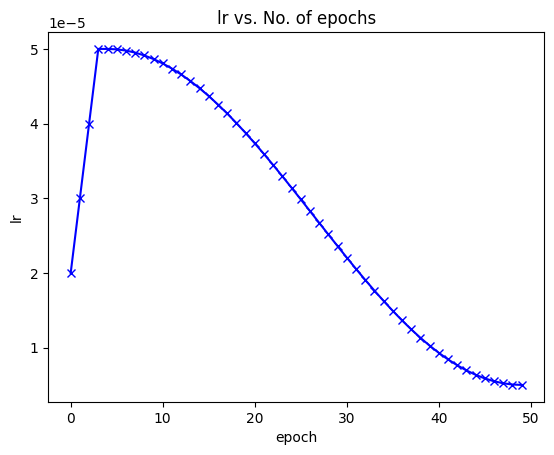

In [22]:
train()

## Inference

In [24]:
model_path = './checkpoint/model.pth'
result_path = 'result'
if os.path.exists(os.path.join('testing_dataset', result_path)):
	os.system(f"rm -rf {os.path.join('testing_dataset', result_path)}")
os.makedirs(os.path.join('testing_dataset',result_path))
output_path = 'output'

if os.path.exists(os.path.join('testing_dataset', output_path)):
	os.system(f"rm -rf {os.path.join('testing_dataset', output_path)}")
os.makedirs(os.path.join('testing_dataset', output_path))


Generate output image

  5%|▌         | 1/20 [00:00<00:09,  2.04it/s]

mean 206.01728439331055
True
mean 164.1035270690918
True
mean 107.83687591552734


 15%|█▌        | 3/20 [00:00<00:03,  4.65it/s]

True
mean 156.5618133544922
True
mean 89.85563278198242


 30%|███       | 6/20 [00:01<00:02,  6.47it/s]

True
mean 154.13091659545898
True


 40%|████      | 8/20 [00:01<00:01,  6.88it/s]

mean 186.73158645629883
True
mean 123.7986946105957
True


 45%|████▌     | 9/20 [00:01<00:01,  7.25it/s]

mean 117.68789291381836
True
mean 98.92845153808594
True


 55%|█████▌    | 11/20 [00:01<00:01,  8.49it/s]

mean 105.50909042358398
True
mean 72.89674758911133
True
mean 209.78960037231445


 70%|███████   | 14/20 [00:02<00:00,  8.56it/s]

True
mean 195.52717208862305
True


 75%|███████▌  | 15/20 [00:02<00:00,  8.69it/s]

mean 103.41573715209961
True
mean 106.74448013305664
True


 85%|████████▌ | 17/20 [00:02<00:00,  8.75it/s]

mean 155.01806259155273
True
mean 191.74610137939453
True


100%|██████████| 20/20 [00:02<00:00,  7.69it/s]

mean 203.34514617919922
True
mean 196.1001205444336
True


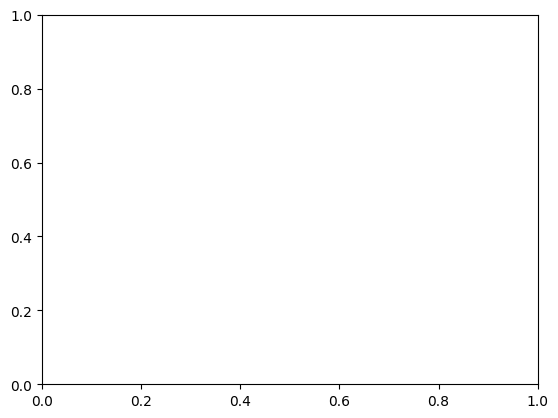

In [25]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = WaterSegmentationDataset(root_dir='testing_dataset', train=False, transform=False)
# load the model
model = WaterSegmentationModel()
model.load_state_dict(torch.load(model_path)['model'], strict=True)
model.to(device)
dl = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

ious = []
model.eval()
with torch.no_grad():
	i = 1
	for img1, img2 in tqdm(dl):
		plt.cla()
		img1 = img1.to(device)
		img2 = img2.to(device)
		output = model(img1, img2)

		output = nn.Sigmoid()(output)
		output = tensor2png_mask(output.squeeze(0))

		print('mean', np.mean(output))
		golden_image = cv2.imread(os.path.join('testing_dataset', 'image', '{}.jpg'.format(i)))
		w, h, _ = golden_image.shape

		output = cv2.resize(output, (h,w), interpolation=cv2.INTER_NEAREST)
		# apply morphology dilation to output
		kernel = np.ones((5,5), np.uint8)
		output = cv2.dilate(output, kernel, iterations=10)

		# remove the sky ( i != 1 and i != 14 and i != 18 and i != 20:)
		post_image = cv2.imread(os.path.join('testing_dataset', 'postprocess_image', '{}.jpg'.format(i)), cv2.IMREAD_GRAYSCALE)
		aux_mask = cv2.imread(os.path.join('testing_dataset', 'aux_mask', '{}.jpg'.format(i)), cv2.IMREAD_GRAYSCALE)
		aux_mask = np.where(aux_mask > 0, 255, 0).astype(np.uint8)
		sky_mask = cv2.imread(os.path.join('testing_dataset', 'sky_image', '{}.jpg'.format(i)), cv2.IMREAD_GRAYSCALE).astype(np.uint8)

		if np.mean(post_image) < 250:
			output[0: h // 3, :] = 0

		assert aux_mask.shape == output.shape and type(aux_mask) == type(output) and aux_mask.dtype == output.dtype
		output = cv2.bitwise_and(output, post_image)
		output = cv2.bitwise_and(output, aux_mask)
		output = cv2.bitwise_and(output, sky_mask)

		output = cv2.dilate(output, kernel, iterations=10)
		# output = cv2.bitwise_and(aux_mask, post_image)
		# iou = IOU(output, golden_mask)
		# print(f'{i}: {iou}')
		# iou = IOU(cv2.imread(os.path.join('testing_dataset', 'processed_image', '{}.jpg'.format(i)), cv2.IMREAD_GRAYSCALE), golden_mask)
		if np.mean(output) > 200:
			print('Warning: The mask is too white')

		print(cv2.imwrite(os.path.join('testing_dataset', output_path, '{}.png'.format(i)), output))
		i += 1

Generate output just for reference (remember to comment the code before submission)

  5%|▌         | 1/20 [00:00<00:13,  1.44it/s]

mean 206.01728439331055
1: 0.9606505328596803
mean 164.1035270690918
2: 0.5575228556515088


 10%|█         | 2/20 [00:00<00:08,  2.16it/s]

mean 107.83687591552734
3: 0.35784322531196855


 15%|█▌        | 3/20 [00:01<00:08,  1.96it/s]

mean 156.5618133544922
4: 0.29755106860314084


 20%|██        | 4/20 [00:01<00:07,  2.17it/s]

mean 89.85563278198242
5: 0.53624866381908


 25%|██▌       | 5/20 [00:02<00:07,  1.99it/s]

mean 154.13091659545898
6: 0.12263282490376737


 30%|███       | 6/20 [00:03<00:07,  1.96it/s]

mean 186.73158645629883
7: 0.26883659839453977


 35%|███▌      | 7/20 [00:03<00:06,  1.91it/s]

mean 123.7986946105957
8: 0.2691407652334536


 40%|████      | 8/20 [00:04<00:06,  1.87it/s]

mean 117.68789291381836
9: 0.3147583109228667


 45%|████▌     | 9/20 [00:04<00:06,  1.79it/s]

mean 98.92845153808594
10: 0.5676935239139582


 50%|█████     | 10/20 [00:05<00:04,  2.06it/s]

mean 105.50909042358398
11: 0.19334575639505336


 60%|██████    | 12/20 [00:05<00:03,  2.58it/s]

mean 72.89674758911133
12: 0.4393785416378729
mean 209.78960037231445
13: 0.8741266546607396


 65%|██████▌   | 13/20 [00:06<00:02,  2.36it/s]

mean 195.52717208862305
14: 0.35075088341698907


 70%|███████   | 14/20 [00:06<00:02,  2.12it/s]

mean 103.41573715209961
15: 0.5872147847986215


 75%|███████▌  | 15/20 [00:07<00:02,  2.12it/s]

mean 106.74448013305664
16: 0.3056398488337573


 80%|████████  | 16/20 [00:07<00:01,  2.36it/s]

mean 155.01806259155273
17: 0.5062166563500543


 90%|█████████ | 18/20 [00:08<00:00,  2.34it/s]

mean 191.74610137939453
18: 0.07293523897164549
mean 203.34514617919922
19: 0.8435988479178516


 95%|█████████▌| 19/20 [00:08<00:00,  2.34it/s]/tmp/ipykernel_201412/2791429632.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 3, figsize=(15, 5))
100%|██████████| 20/20 [00:09<00:00,  2.18it/s]

mean 196.1001205444336
20: 0.8251780832204136
Mean IOU: 0.4626


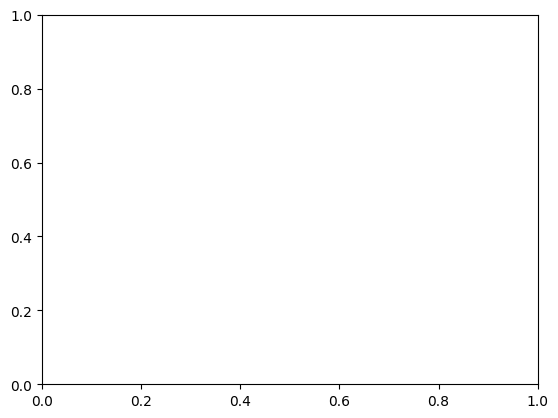

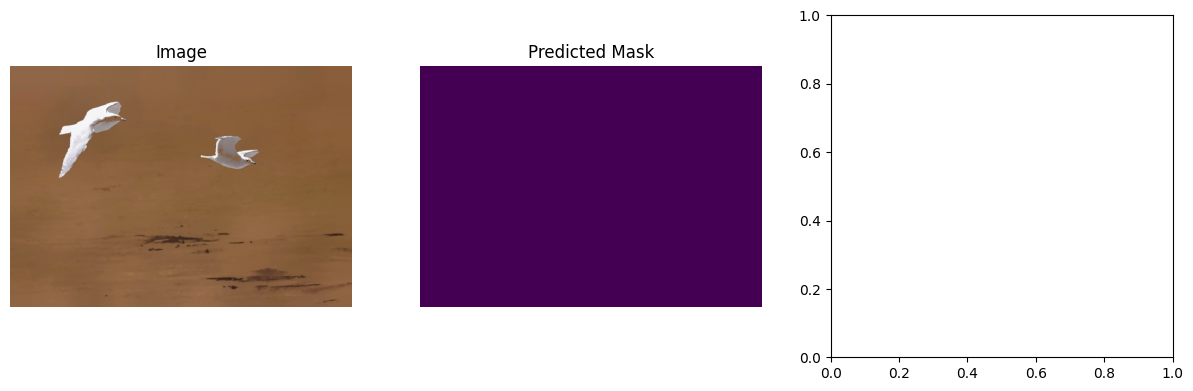

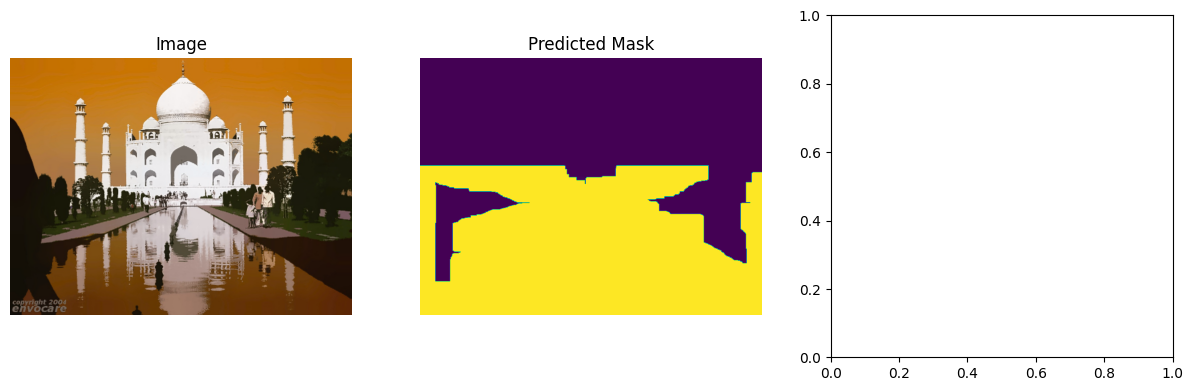

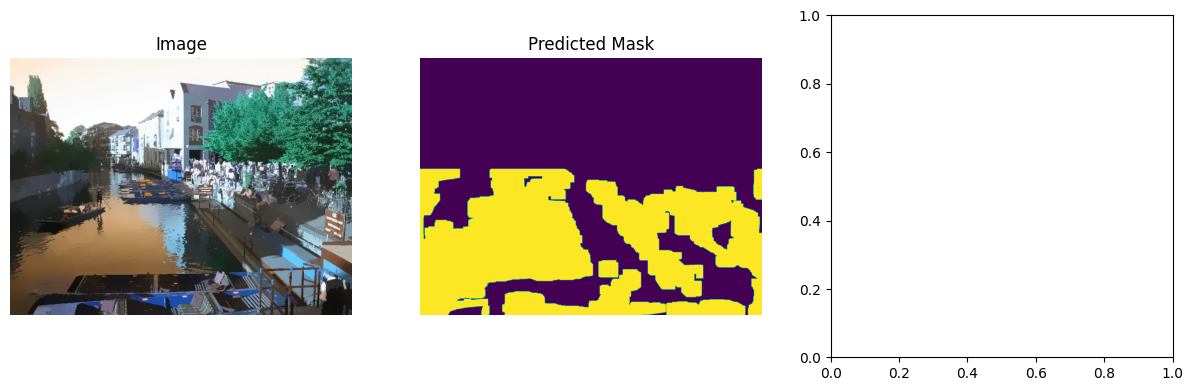

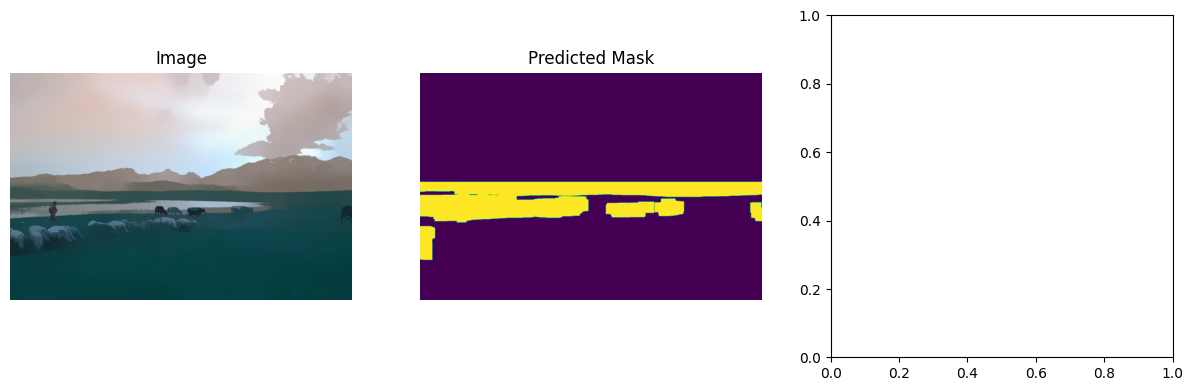

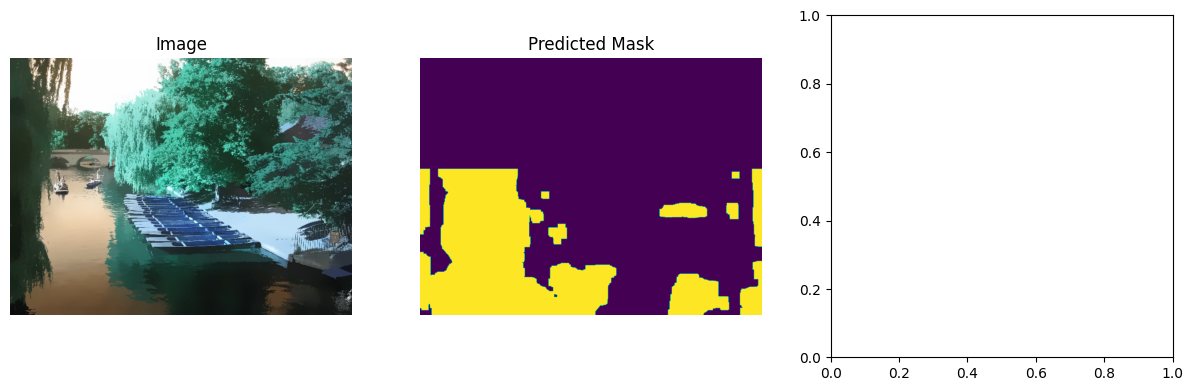

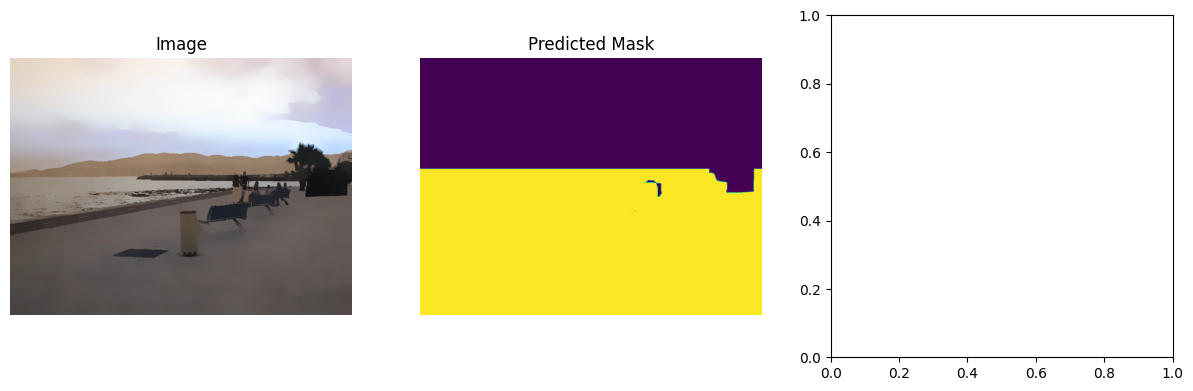

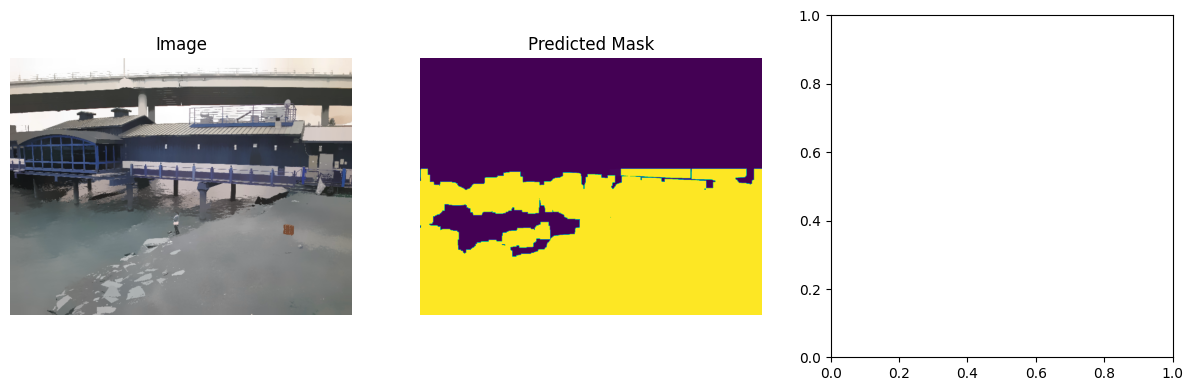

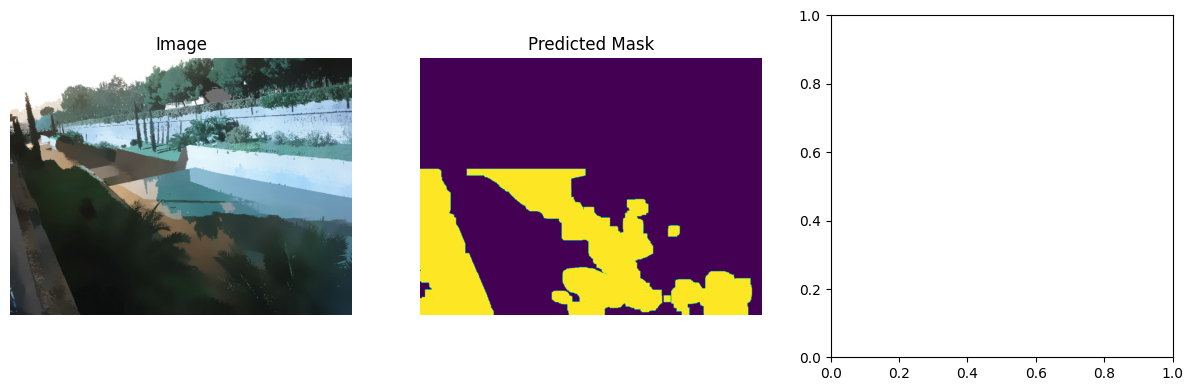

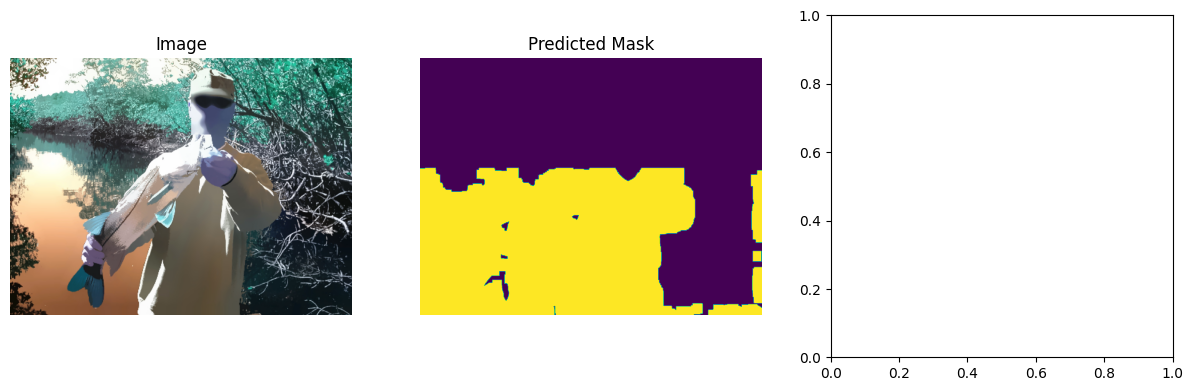

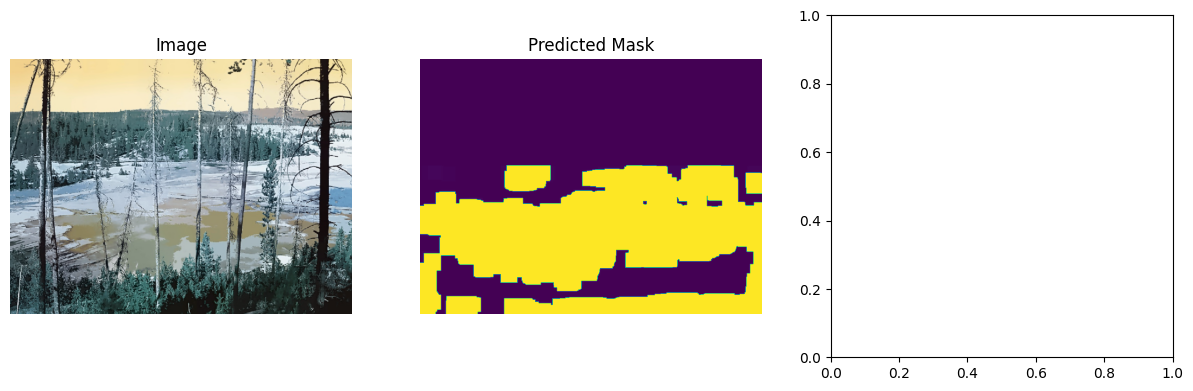

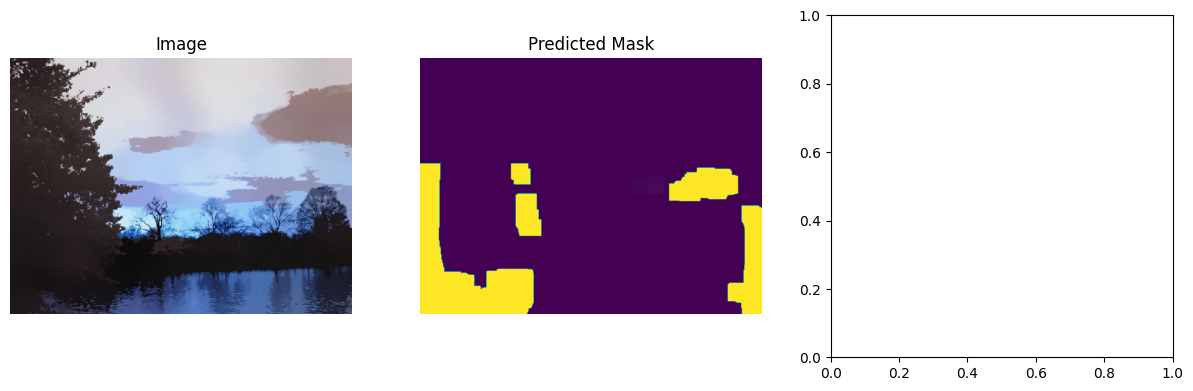

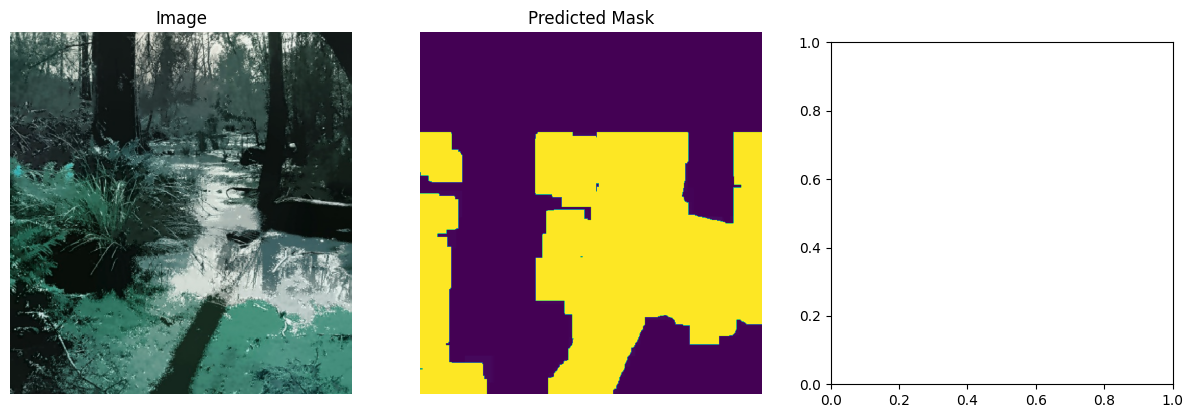

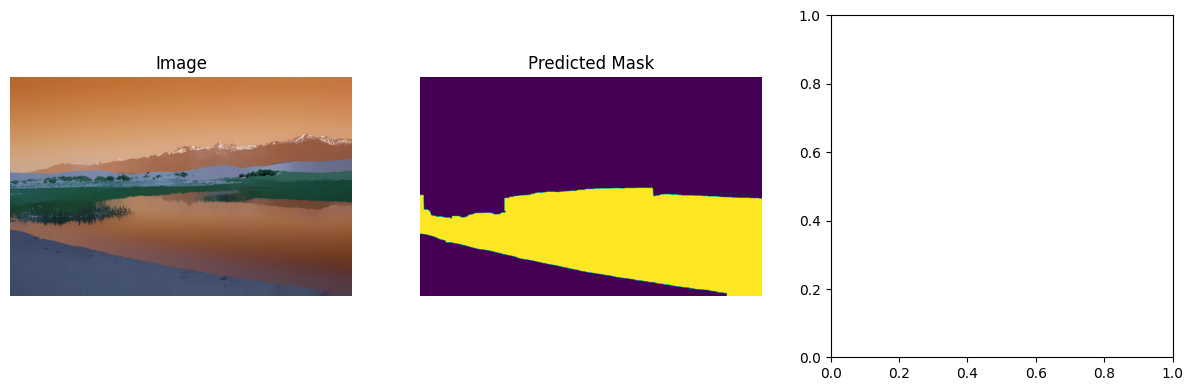

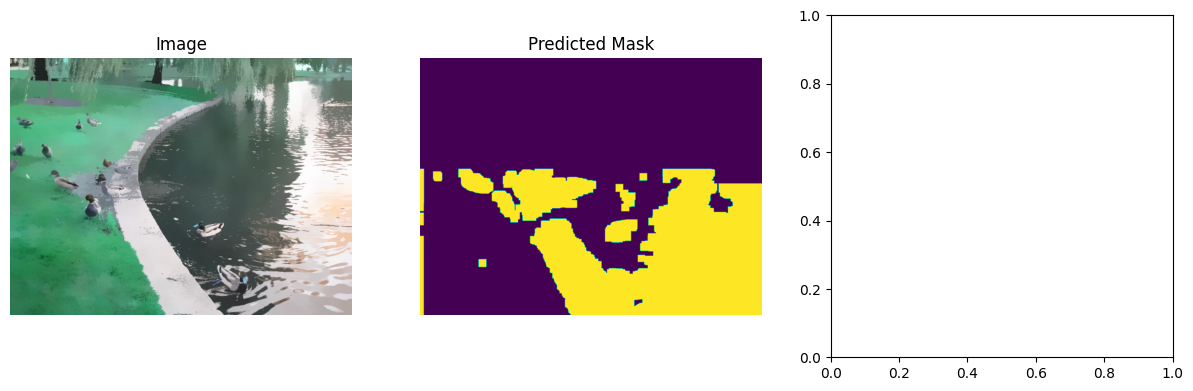

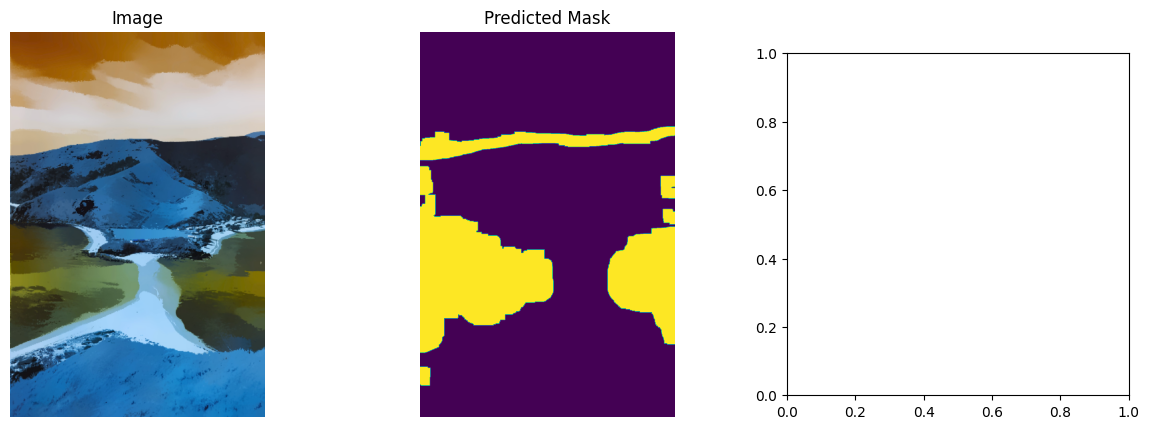

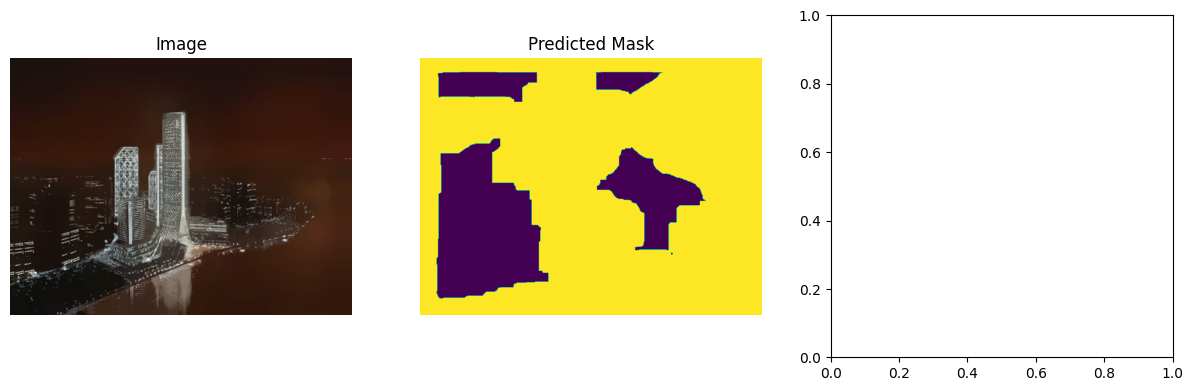

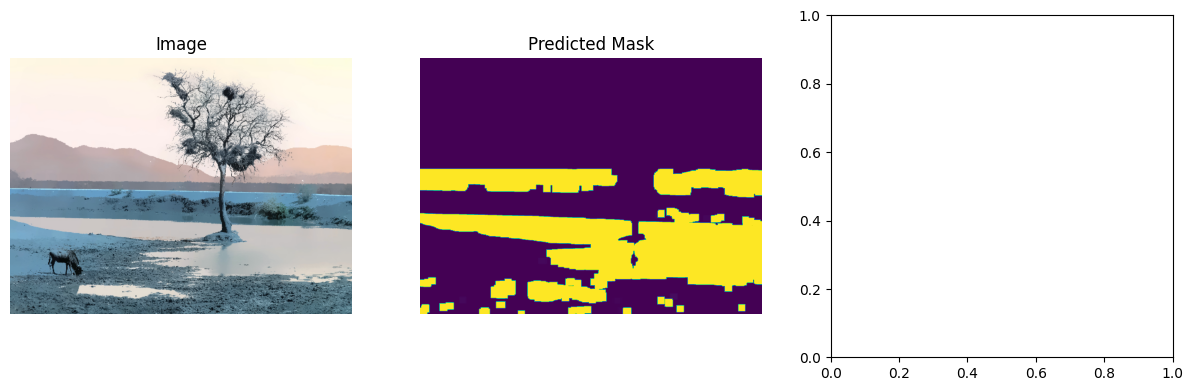

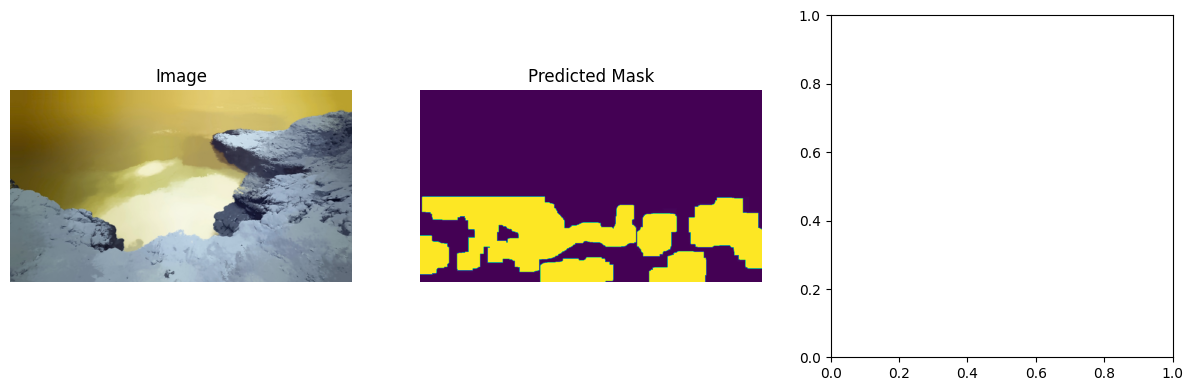

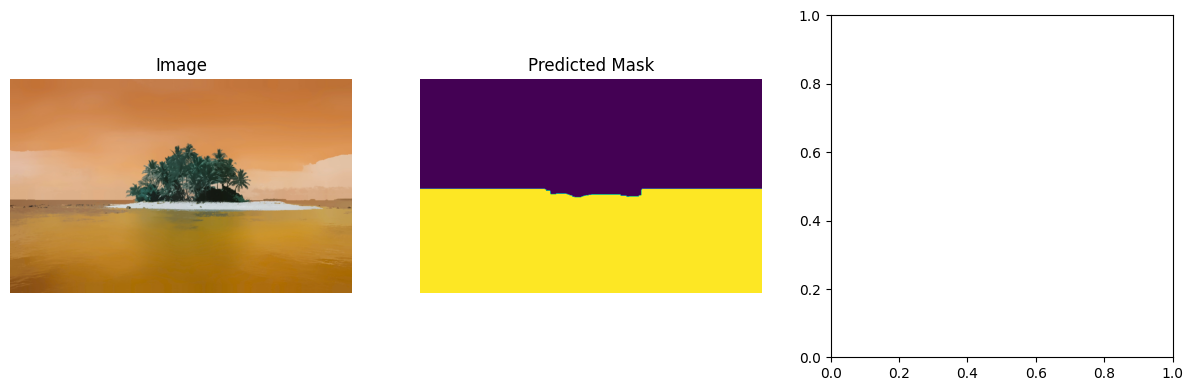

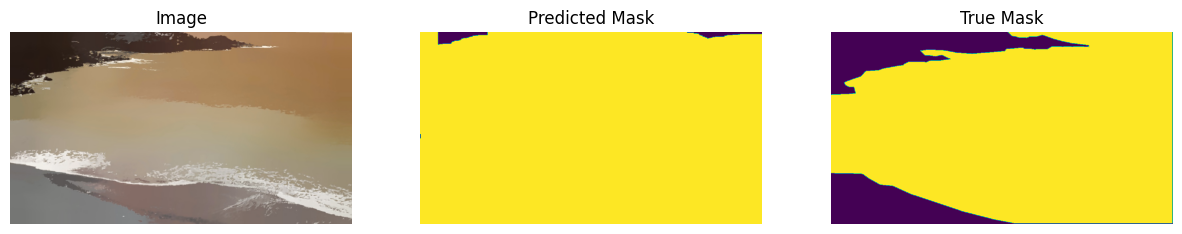

In [26]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dataset = WaterSegmentationDataset(root_dir='testing_dataset', train=True, transform=False)
# dl = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

# ious = []
# with torch.no_grad():
# 	i = 1
# 	for img1, img2, target in tqdm(dl):
# 		plt.cla()
# 		img1 = img1.to(device)
# 		img2 = img2.to(device)
# 		output = model(img1, img2)

# 		output = nn.Sigmoid()(output)
# 		output = tensor2png_mask(output.squeeze(0))
# 		image = tensor2png_image(img1.squeeze(0))
# 		mask = tensor2png_mask(target.squeeze(0))
# 		print('mean', np.mean(output))
# 		golden_mask = cv2.imread(os.path.join('testing_dataset', 'mask', '{}.png'.format(i)), cv2.IMREAD_GRAYSCALE)
# 		w, h = golden_mask.shape
# 		# get the index of the top 10% value in the mask
# 		top_index = np.argsort(output.flatten())[::-1]
# 		top_index = [(top // 512, top % 512) for top in top_index]
# 		# for x, y in top_index[0:512]:
# 		#     cv2.circle(image, (y, x), 5, (0, 255, 0), -1)

# 		image = cv2.resize(image, (h,w), interpolation=cv2.INTER_NEAREST)
# 		output = cv2.resize(output, (h,w), interpolation=cv2.INTER_NEAREST)

# 		# apply morphology dilation to output
# 		kernel = np.ones((5,5), np.uint8)
# 		output = cv2.dilate(output, kernel, iterations=10)

# 		# remove the sky ( i != 1 and i != 14 and i != 18 and i != 20:)
# 		post_image = cv2.imread(os.path.join('testing_dataset', 'postprocess_image', '{}.jpg'.format(i)), cv2.IMREAD_GRAYSCALE)
# 		# post_image = cv2.dilate(post_image, kernel, iterations=1)
# 		# cv2.imwrite(os.path.join('testing_dataset', 'postprocess_image2', '{}.jpg'.format(i)), post_image)
# 		aux_mask = cv2.imread(os.path.join('testing_dataset', 'aux_mask', '{}.jpg'.format(i)), cv2.IMREAD_GRAYSCALE)
# 		aux_mask = np.where(aux_mask > 0, 255, 0).astype(np.uint8)
# 		sky_mask = cv2.imread(os.path.join('testing_dataset', 'sky_image', '{}.jpg'.format(i)), cv2.IMREAD_GRAYSCALE).astype(np.uint8)

# 		# print('mean', np.mean(post_image))
# 		# print('var', np.var(image))
# 		if np.mean(post_image) < 250:
# 			output[0: h // 3, :] = 0
# 		assert aux_mask.shape == output.shape and type(aux_mask) == type(output) and aux_mask.dtype == output.dtype
  
# 		cv2.imwrite(os.path.join('testing_dataset', 'wo_mask', '{}.png'.format(i)), output)
# 		output = cv2.bitwise_and(output, post_image)
# 		output = cv2.bitwise_and(output, aux_mask)
# 		output = cv2.bitwise_and(output, sky_mask)
# 		cv2.imwrite(os.path.join('testing_dataset', 'w_mask', '{}.png'.format(i)), output)
# 		output = cv2.dilate(output, kernel, iterations=10)
# 		cv2.imwrite(os.path.join('testing_dataset', 'w_dilate', '{}.png'.format(i)), output)
# 		# output = cv2.bitwise_and(aux_mask, post_image)
# 		iou = IOU(output, golden_mask)
# 		print(f'{i}: {iou}')
# 		# iou = IOU(cv2.imread(os.path.join('testing_dataset', 'processed_image', '{}.jpg'.format(i)), cv2.IMREAD_GRAYSCALE), golden_mask)
# 		if np.mean(output) > 200:
# 			print('Warning: The mask is too white')

# 		ious.append(iou)
# 		# using matplotlib to show three image above
# 		fig, ax = plt.subplots(1, 3, figsize=(15, 5))


# 		ax[0].imshow(image)
# 		ax[0].set_title('Image')


# 		ax[0].axis('off')
# 		ax[1].imshow(output)
# 		ax[1].set_title('Predicted Mask')
# 		ax[1].axis('off')
# 		ax[2].imshow(golden_mask)
# 		ax[2].set_title('True Mask')
# 		ax[2].axis('off')
# 		plt.savefig(os.path.join('testing_dataset', result_path, '{}.png'.format(i)))
# 		i += 1
# 		# exit()
# print('Mean IOU: {:.4f}'.format(np.mean(ious)))